In [6]:
# ======================= Config (한 곳에서 전부 관리) =======================
import sys
sys.path.append(r"D:\timesformer")

from pathlib import Path
import warnings, random, pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ---- Paths
TRAIN_ROOT      = Path(r"D:\golfDataset\dataset\train")
TEST_ROOT       = Path(r"D:\golfDataset\dataset\test")
PRETRAIN_PTH    = Path(r"D:\timesformer\pretrained\TimeSformer_divST_8x32_224_K600.pyth")
EPOCHS_DIR      = Path("epochs"); EPOCHS_DIR.mkdir(exist_ok=True)
BEST_CKPT       = Path("best_timesformer.pth")

# ---- Data / Model
IMG_SIZE               = 224
NUM_FRAMES             = 16
TRAIN_CLIPS_PER_VIDEO  = 1
EVAL_CLIPS_PER_VIDEO   = 8   # 필요시 5~10으로 올리면 변동성↓(시간 비용↑)

# ---- Train hyperparams
BATCH_SIZE     = 2
WORKERS        = 0          # Windows면 2~4 권장, Linux면 더 높여도 OK
LR             = 1e-4
WEIGHT_DECAY   = 0.01
DROPOUT        = 0.2
TRAIN_BLOCK    = 2           # -1이면 전층 학습
VAL_SPLIT      = 0.10        # train -> train/val
BALANCE_METHOD = "class_weight"   # 'none' | 'oversample' | 'class_weight'
EPOCHS         = 20
WARMUP_EPOCHS  = 1
MAX_GRAD_NORM  = 1.0
EARLY_STOP     = 5
LABEL_SMOOTH   = 0.10
SEED           = 42

# (선택) grad accumulation 추가 시
GRAD_ACCUM_STEPS = 2     # 유효 배치 = BATCH_SIZE * GRAD_ACCUM_STEPS = 4

# ---- Logs / UI
CLEAN_OUTPUT         = True
SHOW_TRAIN_BAR       = True
SHOW_EVAL_BAR        = True
PLOT_CM_EVERY_EPOCH  = True
PRINT_EPOCH_SAVE     = True

# ======================= Imports (한 번만) =======================
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
torch.cuda.empty_cache()

from decord import VideoReader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from timesformer.models.vit import TimeSformer

# ======================= Repro / Device =======================
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ======================= Augment / Sampling =======================
def _sample_clip_params(first_frame_tensor):
    scale = (0.8, 1.0)
    i, j, h, w = T.RandomResizedCrop.get_params(first_frame_tensor, scale=scale, ratio=(3/4, 4/3))
    do_hflip = random.random() < 0.5
    cj = T.ColorJitter(0.2, 0.2, 0.2, 0.0)
    fn_idx, b, c, s, h2 = T.ColorJitter.get_params(cj.brightness, cj.contrast, cj.saturation, cj.hue)
    return (i, j, h, w), do_hflip, (fn_idx, b, c, s)

def augment_clip(frames):  # frames: [T, C, H, W]
    (i, j, h, w), do_hflip, (fn_idx, b, c, s) = _sample_clip_params(frames[0])
    out = []
    for f in frames:
        img = TF.to_pil_image(f)
        img = TF.resized_crop(img, i, j, h, w, size=[IMG_SIZE, IMG_SIZE], interpolation=InterpolationMode.BICUBIC)
        if do_hflip: img = TF.hflip(img)
        for fn_id in fn_idx:
            if fn_id == 0: img = TF.adjust_brightness(img, b)
            elif fn_id == 1: img = TF.adjust_contrast(img, c)
            elif fn_id == 2: img = TF.adjust_saturation(img, s)
            elif fn_id == 3: pass
        t = TF.to_tensor(img)
        t = TF.normalize(t, [0.45]*3, [0.225]*3)
        out.append(t)
    return torch.stack(out)

def eval_clip(frames):
    out = []
    for f in frames:
        img = TF.to_pil_image(f)
        img = TF.resize(img, 256, interpolation=InterpolationMode.BICUBIC)
        img = TF.center_crop(img, IMG_SIZE)
        t = TF.to_tensor(img)
        t = TF.normalize(t, [0.45]*3, [0.225]*3)
        out.append(t)
    return torch.stack(out)

def uniform_sample(L, N):
    if L >= N: return np.linspace(0, L-1, N).astype(int)
    return np.pad(np.arange(L), (0, N-L), mode='edge')

def load_clip(path: Path, num_clips: int, train=True):
    vr = VideoReader(str(path))
    L = len(vr)
    if L == 0:
        print(f"[경고] 프레임이 0인 비디오: {path}")
        # 빈 텐서 반환 (혹은 raise Exception)
        return [torch.zeros((3, NUM_FRAMES, IMG_SIZE, IMG_SIZE), dtype=torch.float32) for _ in range(num_clips)]
    seg_edges = np.linspace(0, L, num_clips + 1, dtype=int)
    clips = []
    for s0, s1 in zip(seg_edges[:-1], seg_edges[1:]):
        idx = uniform_sample(s1 - s0, NUM_FRAMES) + s0
        arr = vr.get_batch(idx).asnumpy().astype(np.uint8)
        clip = torch.from_numpy(arr).permute(0, 3, 1, 2).contiguous()
        proc = augment_clip(clip) if train else eval_clip(clip)
        clips.append(proc.permute(1, 0, 2, 3))
    return clips

# ======================= Dataset / Loader =======================
class GolfSwingDataset(Dataset):
    def __init__(self, root: Path, balance="none", train=True, verbose=True):
        self.train = train
        true_samples, false_samples = [], []
        for label, sub in [(1, "balanced_true"), (0, "false")]:
            mp4_dir = (root / sub / "crop_video")
            if mp4_dir.exists():
                for p in mp4_dir.glob("*.mp4"):
                    (true_samples if label==1 else false_samples).append((p, label))

        if balance == "oversample":
            n_true, n_false = len(true_samples), len(false_samples)
            if n_false > 0 and n_true > n_false:
                factor, remainder = n_true // n_false, n_true % n_false
                false_samples = false_samples * factor + false_samples[:remainder]

        self.samples = true_samples + false_samples
        random.shuffle(self.samples)
        if verbose:
            print(f"✅ {len(self.samples)} samples found in {root} (balance='{balance}')")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        num_clips = TRAIN_CLIPS_PER_VIDEO if self.train else EVAL_CLIPS_PER_VIDEO
        clips = load_clip(path, num_clips=num_clips, train=self.train)
        return torch.stack(clips), torch.tensor(label)

def filesystem_class_weights(train_root: Path, num_classes=2):
    true_cnt  = len(list((train_root/"balanced_true"/"crop_video").glob("*.mp4")))
    false_cnt = len(list((train_root/"false"/"crop_video").glob("*.mp4")))
    cnts = {1: true_cnt, 0: false_cnt}
    total = sum(cnts.values())
    if total == 0: return torch.ones(num_classes, dtype=torch.float32)
    w = [total / max(1, cnts.get(c, 0)) for c in range(num_classes)]
    s = sum(w); w = [wi * (num_classes / s) for wi in w]
    return torch.tensor(w, dtype=torch.float32)

# oversample + class_weight 동시 사용 경고 (과벌점 위험)
if BALANCE_METHOD == "oversample":
    print("⚠️  현재 oversample 사용 중입니다. val/test는 항상 balance='none'으로 평가합니다.")
elif BALANCE_METHOD == "class_weight":
    print("ℹ️  현재 class_weight 사용 중입니다. oversample과 동시 사용은 피하세요.")

# 1) 전체 트레인 세트(증강/오버샘플 옵션 포함)
train_full = GolfSwingDataset(
    TRAIN_ROOT,
    balance=("oversample" if BALANCE_METHOD=="oversample" else "none"),
    train=True,
    verbose=not CLEAN_OUTPUT
)

# 2) 인덱스 분할만 얻기
val_len = max(1, int(len(train_full) * VAL_SPLIT))
train_len = len(train_full) - val_len
g = torch.Generator().manual_seed(SEED)
train_subset, val_subset = random_split(train_full, [train_len, val_len], generator=g)

# 3) 동일한 샘플 목록을 공유하되, 서로 다른 'train 플래그'를 갖는 별도 Dataset 인스턴스 생성
def clone_dataset_with_indices(src_ds: GolfSwingDataset, indices, train_flag: bool, balance: str):
    ds = GolfSwingDataset(TRAIN_ROOT, balance=balance, train=train_flag, verbose=False)
    ds.samples = [src_ds.samples[i] for i in indices]   # 원본에서 선택된 샘플만 복사
    return ds

train_dataset = clone_dataset_with_indices(
    train_full, train_subset.indices, train_flag=True,
    balance=("oversample" if BALANCE_METHOD=="oversample" else "none")
)
val_dataset   = clone_dataset_with_indices(
    train_full, val_subset.indices,   train_flag=False, balance="none"
)

# 4) 테스트 세트는 원래대로 (평가 전용이므로 train=False)
test_dataset  = GolfSwingDataset(TEST_ROOT, balance="none", train=False, verbose=not CLEAN_OUTPUT)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=True)

# ======================= Model / Optim =======================
class TimeSformerWithDropout(nn.Module):
    def __init__(self, base_model, dropout_p=DROPOUT):
        super().__init__()
        self.base = base_model
        self.dropout = nn.Dropout(dropout_p)
        self.head = getattr(self.base, "head", None)
        if self.head is None and hasattr(self.base, "model"):
            self.head = self.base.model.head

    def forward(self, x):
        base = self.base
        if hasattr(base, "forward_features"): feats = base.forward_features(x)
        elif hasattr(base, "model") and hasattr(base.model, "forward_features"): feats = base.model.forward_features(x)
        else: feats = base(x)
        return self.head(self.dropout(feats))

base_model = TimeSformer(
    img_size=IMG_SIZE, num_frames=NUM_FRAMES, num_classes=2,
    attention_type='divided_space_time',
    pretrained_model=str(PRETRAIN_PTH)
).to(DEVICE)
model = TimeSformerWithDropout(base_model, dropout_p=DROPOUT).to(DEVICE)

def get_trainable_params(model, train_blocks: int):
    base = model.base if hasattr(model, "base") else model
    inner = base.model if hasattr(base, "model") else base
    if train_blocks == -1:
        for p in base.parameters(): p.requires_grad = True
        return [p for p in base.parameters() if p.requires_grad]
    # Freeze all
    for p in base.parameters(): p.requires_grad = False
    # Unfreeze head
    head = getattr(inner, "head", None)
    if head is not None:
        for p in head.parameters(): p.requires_grad = True
    # Unfreeze last N blocks
    blocks = getattr(inner, "blocks", None)
    if blocks is not None and isinstance(blocks, (list, nn.ModuleList, nn.Sequential)):
        total = len(blocks); start = max(0, total - train_blocks)
        for b in blocks[start:]:
            for p in b.parameters(): p.requires_grad = True
    return [p for p in base.parameters() if p.requires_grad]

def build_optimizer(model, train_blocks: int, base_lr=LR, weight_decay=WEIGHT_DECAY):
    base = model.base if hasattr(model, "base") else model
    inner = base.model if hasattr(base, "model") else base
    head = getattr(inner, "head", None)
    head_params = list(head.parameters()) if head is not None else []

    if train_blocks == -1:
        head_set = set(head_params)
        backbone_params = [p for p in base.parameters() if p.requires_grad and p not in head_set]
        param_groups = [
            {"params": head_params,     "lr": base_lr * 2.0, "weight_decay": weight_decay},
            {"params": backbone_params, "lr": base_lr * 0.5, "weight_decay": weight_decay},
        ]
    else:
        blocks = getattr(inner, "blocks", None)
        block_params = []
        if blocks is not None and isinstance(blocks, (list, nn.ModuleList, nn.Sequential)):
            total = len(blocks); start = max(0, total - train_blocks)
            for b in blocks[start:]:
                block_params += [p for p in b.parameters() if p.requires_grad]
        param_groups = [
            {"params": head_params,  "lr": base_lr * 2.0, "weight_decay": weight_decay},
            {"params": block_params, "lr": base_lr * 1.0, "weight_decay": weight_decay},
        ]

    opt = optim.AdamW(param_groups)
    # === LR 스케줄러가 그룹 비율을 유지하도록 initial_lr 저장 ===
    for g in opt.param_groups:
        g["initial_lr"] = g["lr"]
    return opt

trainable_params = get_trainable_params(model, TRAIN_BLOCK)
optimizer = build_optimizer(model, TRAIN_BLOCK, base_lr=LR, weight_decay=WEIGHT_DECAY)

# Class weights (옵션)
if BALANCE_METHOD == "class_weight":
    class_w = filesystem_class_weights(TRAIN_ROOT).to(DEVICE)
else:
    class_w = None
criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=LABEL_SMOOTH)

# AMP & LR schedule — 그룹 비율 유지형 스케일 팩터
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

def get_lr_factor(epoch):
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(max(1, WARMUP_EPOCHS))
    t = epoch - WARMUP_EPOCHS
    T_total = max(1, EPOCHS - WARMUP_EPOCHS)
    return 0.5 * (1 + np.cos(np.pi * t / T_total))

def set_lr_with_factor(optimr, factor):
    for g in optimr.param_groups:
        g['lr'] = g['initial_lr'] * factor

# ======================= Train / Eval =======================
def video_level_from_logits(logits, B, clips_per_video):
    return logits.view(B, clips_per_video, -1).mean(dim=1)

# ======================= Config (한 곳에서 전부 관리) =======================
import sys
sys.path.append(r"D:\timesformer")

from pathlib import Path
import warnings, random, pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ---- Paths
TRAIN_ROOT      = Path(r"D:\golfDataset\dataset\train")
TEST_ROOT       = Path(r"D:\golfDataset\dataset\test")
PRETRAIN_PTH    = Path(r"D:\timesformer\pretrained\TimeSformer_divST_8x32_224_K600.pyth")
EPOCHS_DIR      = Path("epochs"); EPOCHS_DIR.mkdir(exist_ok=True)
BEST_CKPT       = Path("best_timesformer.pth")

# ---- Data / Model
IMG_SIZE               = 224
NUM_FRAMES             = 16
TRAIN_CLIPS_PER_VIDEO  = 1
EVAL_CLIPS_PER_VIDEO   = 8   # 필요시 5~10으로 올리면 변동성↓(시간 비용↑)

# ---- Train hyperparams
BATCH_SIZE     = 2
WORKERS        = 0          # Windows면 2~4 권장, Linux면 더 높여도 OK
LR             = 1e-4
WEIGHT_DECAY   = 0.01
DROPOUT        = 0.2
TRAIN_BLOCK    = 2           # -1이면 전층 학습
VAL_SPLIT      = 0.10        # train -> train/val
BALANCE_METHOD = "class_weight"   # 'none' | 'oversample' | 'class_weight'
EPOCHS         = 20
WARMUP_EPOCHS  = 1
MAX_GRAD_NORM  = 1.0
EARLY_STOP     = 5
LABEL_SMOOTH   = 0.10
SEED           = 42

# (선택) grad accumulation 추가 시
GRAD_ACCUM_STEPS = 2     # 유효 배치 = BATCH_SIZE * GRAD_ACCUM_STEPS = 4

# ---- Logs / UI
CLEAN_OUTPUT         = True
SHOW_TRAIN_BAR       = True
SHOW_EVAL_BAR        = True
PLOT_CM_EVERY_EPOCH  = True
PRINT_EPOCH_SAVE     = True

# ======================= Imports (한 번만) =======================
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
torch.cuda.empty_cache()

from decord import VideoReader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from timesformer.models.vit import TimeSformer

# ======================= Repro / Device =======================
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ======================= Augment / Sampling =======================
def _sample_clip_params(first_frame_tensor):
    scale = (0.8, 1.0)
    i, j, h, w = T.RandomResizedCrop.get_params(first_frame_tensor, scale=scale, ratio=(3/4, 4/3))
    do_hflip = random.random() < 0.5
    cj = T.ColorJitter(0.2, 0.2, 0.2, 0.0)
    fn_idx, b, c, s, h2 = T.ColorJitter.get_params(cj.brightness, cj.contrast, cj.saturation, cj.hue)
    return (i, j, h, w), do_hflip, (fn_idx, b, c, s)

def augment_clip(frames):  # frames: [T, C, H, W]
    (i, j, h, w), do_hflip, (fn_idx, b, c, s) = _sample_clip_params(frames[0])
    out = []
    for f in frames:
        img = TF.to_pil_image(f)
        img = TF.resized_crop(img, i, j, h, w, size=[IMG_SIZE, IMG_SIZE], interpolation=InterpolationMode.BICUBIC)
        if do_hflip: img = TF.hflip(img)
        for fn_id in fn_idx:
            if fn_id == 0: img = TF.adjust_brightness(img, b)
            elif fn_id == 1: img = TF.adjust_contrast(img, c)
            elif fn_id == 2: img = TF.adjust_saturation(img, s)
            elif fn_id == 3: pass
        t = TF.to_tensor(img)
        t = TF.normalize(t, [0.45]*3, [0.225]*3)
        out.append(t)
    return torch.stack(out)

def eval_clip(frames):
    out = []
    for f in frames:
        img = TF.to_pil_image(f)
        img = TF.resize(img, 256, interpolation=InterpolationMode.BICUBIC)
        img = TF.center_crop(img, IMG_SIZE)
        t = TF.to_tensor(img)
        t = TF.normalize(t, [0.45]*3, [0.225]*3)
        out.append(t)
    return torch.stack(out)

def uniform_sample(L, N):
    if L >= N: return np.linspace(0, L-1, N).astype(int)
    return np.pad(np.arange(L), (0, N-L), mode='edge')

def load_clip(path: Path, num_clips: int, train=True):
    vr = VideoReader(str(path))
    L = len(vr)
    if L == 0:
        print(f"[경고] 프레임이 0인 비디오: {path}")
        # 빈 텐서 반환 (혹은 raise Exception)
        return [torch.zeros((3, NUM_FRAMES, IMG_SIZE, IMG_SIZE), dtype=torch.float32) for _ in range(num_clips)]
    seg_edges = np.linspace(0, L, num_clips + 1, dtype=int)
    clips = []
    for s0, s1 in zip(seg_edges[:-1], seg_edges[1:]):
        idx = uniform_sample(s1 - s0, NUM_FRAMES) + s0
        arr = vr.get_batch(idx).asnumpy().astype(np.uint8)
        clip = torch.from_numpy(arr).permute(0, 3, 1, 2).contiguous()
        proc = augment_clip(clip) if train else eval_clip(clip)
        clips.append(proc.permute(1, 0, 2, 3))
    return clips

# ======================= Dataset / Loader =======================
class GolfSwingDataset(Dataset):
    def __init__(self, root: Path, balance="none", train=True, verbose=True):
        self.train = train
        true_samples, false_samples = [], []
        for label, sub in [(1, "balanced_true"), (0, "false")]:
            mp4_dir = (root / sub / "crop_video")
            if mp4_dir.exists():
                for p in mp4_dir.glob("*.mp4"):
                    (true_samples if label==1 else false_samples).append((p, label))

        if balance == "oversample":
            n_true, n_false = len(true_samples), len(false_samples)
            if n_false > 0 and n_true > n_false:
                factor, remainder = n_true // n_false, n_true % n_false
                false_samples = false_samples * factor + false_samples[:remainder]

        self.samples = true_samples + false_samples
        random.shuffle(self.samples)
        if verbose:
            print(f"✅ {len(self.samples)} samples found in {root} (balance='{balance}')")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        num_clips = TRAIN_CLIPS_PER_VIDEO if self.train else EVAL_CLIPS_PER_VIDEO
        clips = load_clip(path, num_clips=num_clips, train=self.train)
        return torch.stack(clips), torch.tensor(label)

def filesystem_class_weights(train_root: Path, num_classes=2):
    true_cnt  = len(list((train_root/"balanced_true"/"crop_video").glob("*.mp4")))
    false_cnt = len(list((train_root/"false"/"crop_video").glob("*.mp4")))
    cnts = {1: true_cnt, 0: false_cnt}
    total = sum(cnts.values())
    if total == 0: return torch.ones(num_classes, dtype=torch.float32)
    w = [total / max(1, cnts.get(c, 0)) for c in range(num_classes)]
    s = sum(w); w = [wi * (num_classes / s) for wi in w]
    return torch.tensor(w, dtype=torch.float32)

# oversample + class_weight 동시 사용 경고 (과벌점 위험)
if BALANCE_METHOD == "oversample":
    print("⚠️  현재 oversample 사용 중입니다. val/test는 항상 balance='none'으로 평가합니다.")
elif BALANCE_METHOD == "class_weight":
    print("ℹ️  현재 class_weight 사용 중입니다. oversample과 동시 사용은 피하세요.")

# 1) 전체 트레인 세트(증강/오버샘플 옵션 포함)
train_full = GolfSwingDataset(
    TRAIN_ROOT,
    balance=("oversample" if BALANCE_METHOD=="oversample" else "none"),
    train=True,
    verbose=not CLEAN_OUTPUT
)

# 2) 인덱스 분할만 얻기
val_len = max(1, int(len(train_full) * VAL_SPLIT))
train_len = len(train_full) - val_len
g = torch.Generator().manual_seed(SEED)
train_subset, val_subset = random_split(train_full, [train_len, val_len], generator=g)

# 3) 동일한 샘플 목록을 공유하되, 서로 다른 'train 플래그'를 갖는 별도 Dataset 인스턴스 생성
def clone_dataset_with_indices(src_ds: GolfSwingDataset, indices, train_flag: bool, balance: str):
    ds = GolfSwingDataset(TRAIN_ROOT, balance=balance, train=train_flag, verbose=False)
    ds.samples = [src_ds.samples[i] for i in indices]   # 원본에서 선택된 샘플만 복사
    return ds

train_dataset = clone_dataset_with_indices(
    train_full, train_subset.indices, train_flag=True,
    balance=("oversample" if BALANCE_METHOD=="oversample" else "none")
)
val_dataset   = clone_dataset_with_indices(
    train_full, val_subset.indices,   train_flag=False, balance="none"
)

# 4) 테스트 세트는 원래대로 (평가 전용이므로 train=False)
test_dataset  = GolfSwingDataset(TEST_ROOT, balance="none", train=False, verbose=not CLEAN_OUTPUT)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=True)

# ======================= Model / Optim =======================
class TimeSformerWithDropout(nn.Module):
    def __init__(self, base_model, dropout_p=DROPOUT):
        super().__init__()
        self.base = base_model
        self.dropout = nn.Dropout(dropout_p)
        self.head = getattr(self.base, "head", None)
        if self.head is None and hasattr(self.base, "model"):
            self.head = self.base.model.head

    def forward(self, x):
        base = self.base
        if hasattr(base, "forward_features"): feats = base.forward_features(x)
        elif hasattr(base, "model") and hasattr(base.model, "forward_features"): feats = base.model.forward_features(x)
        else: feats = base(x)
        return self.head(self.dropout(feats))

base_model = TimeSformer(
    img_size=IMG_SIZE, num_frames=NUM_FRAMES, num_classes=2,
    attention_type='divided_space_time',
    pretrained_model=str(PRETRAIN_PTH)
).to(DEVICE)
model = TimeSformerWithDropout(base_model, dropout_p=DROPOUT).to(DEVICE)

def get_trainable_params(model, train_blocks: int):
    base = model.base if hasattr(model, "base") else model
    inner = base.model if hasattr(base, "model") else base
    if train_blocks == -1:
        for p in base.parameters(): p.requires_grad = True
        return [p for p in base.parameters() if p.requires_grad]
    # Freeze all
    for p in base.parameters(): p.requires_grad = False
    # Unfreeze head
    head = getattr(inner, "head", None)
    if head is not None:
        for p in head.parameters(): p.requires_grad = True
    # Unfreeze last N blocks
    blocks = getattr(inner, "blocks", None)
    if blocks is not None and isinstance(blocks, (list, nn.ModuleList, nn.Sequential)):
        total = len(blocks); start = max(0, total - train_blocks)
        for b in blocks[start:]:
            for p in b.parameters(): p.requires_grad = True
    return [p for p in base.parameters() if p.requires_grad]

def build_optimizer(model, train_blocks: int, base_lr=LR, weight_decay=WEIGHT_DECAY):
    base = model.base if hasattr(model, "base") else model
    inner = base.model if hasattr(base, "model") else base
    head = getattr(inner, "head", None)
    head_params = list(head.parameters()) if head is not None else []

    if train_blocks == -1:
        head_set = set(head_params)
        backbone_params = [p for p in base.parameters() if p.requires_grad and p not in head_set]
        param_groups = [
            {"params": head_params,     "lr": base_lr * 2.0, "weight_decay": weight_decay},
            {"params": backbone_params, "lr": base_lr * 0.5, "weight_decay": weight_decay},
        ]
    else:
        blocks = getattr(inner, "blocks", None)
        block_params = []
        if blocks is not None and isinstance(blocks, (list, nn.ModuleList, nn.Sequential)):
            total = len(blocks); start = max(0, total - train_blocks)
            for b in blocks[start:]:
                block_params += [p for p in b.parameters() if p.requires_grad]
        param_groups = [
            {"params": head_params,  "lr": base_lr * 2.0, "weight_decay": weight_decay},
            {"params": block_params, "lr": base_lr * 1.0, "weight_decay": weight_decay},
        ]

    opt = optim.AdamW(param_groups)
    # === LR 스케줄러가 그룹 비율을 유지하도록 initial_lr 저장 ===
    for g in opt.param_groups:
        g["initial_lr"] = g["lr"]
    return opt

trainable_params = get_trainable_params(model, TRAIN_BLOCK)
optimizer = build_optimizer(model, TRAIN_BLOCK, base_lr=LR, weight_decay=WEIGHT_DECAY)

# Class weights (옵션)
if BALANCE_METHOD == "class_weight":
    class_w = filesystem_class_weights(TRAIN_ROOT).to(DEVICE)
else:
    class_w = None
criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=LABEL_SMOOTH)

# AMP & LR schedule — 그룹 비율 유지형 스케일 팩터
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

def get_lr_factor(epoch):
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(max(1, WARMUP_EPOCHS))
    t = epoch - WARMUP_EPOCHS
    T_total = max(1, EPOCHS - WARMUP_EPOCHS)
    return 0.5 * (1 + np.cos(np.pi * t / T_total))

def set_lr_with_factor(optimr, factor):
    for g in optimr.param_groups:
        g['lr'] = g['initial_lr'] * factor

# ======================= Train / Eval =======================
def video_level_from_logits(logits, B, clips_per_video):
    return logits.view(B, clips_per_video, -1).mean(dim=1)

train_logs = {"train_acc": [], "val_acc": [], "train_loss": []}
val_acc_per_epoch, best_val_acc, patience = [], -1.0, 0

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    lr_factor = get_lr_factor(epoch)
    set_lr_with_factor(optimizer, lr_factor)

    total_videos = correct_videos = 0
    running_loss, running_steps = 0.0, 0

    bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]",
            ncols=80, leave=False, disable=not SHOW_TRAIN_BAR)

    optimizer.zero_grad(set_to_none=True)  # ✅ 루프 시작 전에 1번만

    for step, (clips, label) in enumerate(bar):
        B = clips.shape[0]
        vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)               # [B*C, C,T,H,W]
        labs = label.repeat_interleave(TRAIN_CLIPS_PER_VIDEO).to(DEVICE) # 라벨 확장

        with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
            outs = model(vids)                                            # [B*C, 2]
            loss = criterion(outs, labs)

        # ✅ 누적: 스케일한 loss를 나눠서 backward
        scaler.scale(loss / GRAD_ACCUM_STEPS).backward()

        # 로깅은 원래 loss 기준으로
        running_loss += loss.item()
        running_steps += 1

        # 비디오 단위 정확도 갱신(로짓 평균)
        with torch.no_grad():
            vid_logits = video_level_from_logits(outs, B, TRAIN_CLIPS_PER_VIDEO)
            preds = vid_logits.argmax(1).cpu()
            correct_videos += (preds == label).sum().item()
            total_videos   += B

        # ✅ 누적 step마다만 step/zero_grad
        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            # AMP 사용 시, clip 전에 unscale 권장
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(trainable_params, MAX_GRAD_NORM)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        if SHOW_TRAIN_BAR:
            bar.set_postfix({
                "Loss": f"{running_loss/max(1,running_steps):.4f}",
                "Acc":  f"{correct_videos/max(1,total_videos):.2%}"
            })

    # ✅ 마지막에 남은 그라디언트 처리(미완 배치가 있을 때)
    remainder = (step + 1) % GRAD_ACCUM_STEPS
    if remainder != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(trainable_params, MAX_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    train_acc = correct_videos / max(1, total_videos)
    avg_loss  = running_loss / max(1, running_steps)
    train_logs["train_acc"].append(train_acc); train_logs["train_loss"].append(avg_loss)

    # ---- Val ----
    model.eval(); all_preds, all_labels = [], []
    val_total = val_correct = 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]",
                    ncols=80, leave=False, disable=not SHOW_EVAL_BAR)
        for clips, label in vbar:
            B = clips.shape[0]
            vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)
            with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
                outs = model(vids)
                vid_logits = video_level_from_logits(outs, B, EVAL_CLIPS_PER_VIDEO)
                pred = vid_logits.argmax(1).cpu()
            val_total += B; val_correct += (pred == label).sum().item()
            if SHOW_EVAL_BAR: vbar.set_postfix({"Acc": f"{val_correct/max(1,val_total):.2%}"})
            all_preds.extend(pred.numpy()); all_labels.extend(label.numpy())

    val_acc = val_correct / max(1, val_total)
    train_logs["val_acc"].append(val_acc); val_acc_per_epoch.append(val_acc)

    if PLOT_CM_EVERY_EPOCH:
        cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False","True"])
        disp.plot(cmap="Blues"); plt.title(f"Val Confusion Matrix (Epoch {epoch+1})"); plt.show()

    # ---- Early stop / Save best (val 기준)
    if val_acc > best_val_acc:
        best_val_acc, patience = val_acc, 0
        torch.save({"epoch": epoch, "model": model.state_dict(),
                    "opt": optimizer.state_dict(), "metrics": {"val_acc": val_acc}}, BEST_CKPT)
        if not CLEAN_OUTPUT or PRINT_EPOCH_SAVE:
            print(f"  ✅ Best updated: val_acc={val_acc:.3%} -> saved to {BEST_CKPT}")
    else:
        patience += 1
        if patience >= EARLY_STOP:
            print("⛳ Early stopping triggered."); break

    if CLEAN_OUTPUT:
        print(f"Epoch {epoch+1}/{EPOCHS} | train_acc={train_acc:.3%} loss={avg_loss:.4f} "
              f"| val_acc={val_acc:.3%} | best={best_val_acc:.3%}")

    with open("train_logs.pkl", "wb") as f:
        pickle.dump(train_logs, f)



ℹ️  현재 class_weight 사용 중입니다. oversample과 동시 사용은 피하세요.
ℹ️  현재 class_weight 사용 중입니다. oversample과 동시 사용은 피하세요.


KeyboardInterrupt: 

[Test]: 100%|█████████████████████████████████| 257/257 [08:59<00:00,  2.10s/it]


✅ Test Accuracy: 72.515%
🔎 Balanced Acc : 51.874%
🔎 Macro F1     : 46.983%
🔎 ROC-AUC      : 0.540
🔎 PR-AUC(AP)   : 0.742

[Per-class]
 false(0) -> P:0.533 R:0.056 F1:0.102 (n=142)
 true (1) -> P:0.731 R:0.981 F1:0.838 (n=371)


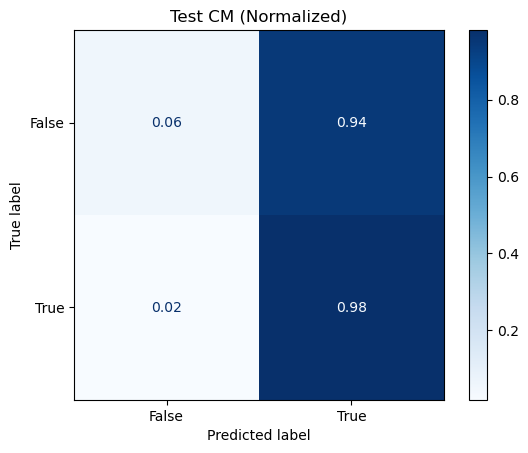

In [7]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, f1_score, roc_auc_score, average_precision_score,
    precision_recall_fscore_support
)
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ======================= Final Test (정확도 + 불균형 지표) =======================
# 필요시 아래 주석 해제 (학습 후 바로 테스트할 경우 생략 가능)
model.load_state_dict(torch.load(BEST_CKPT)["model"])

model.eval(); all_preds, all_labels, all_scores = [], [], []
with torch.no_grad():
    for clips, label in tqdm(test_loader, desc="[Test]", ncols=80, disable=not SHOW_EVAL_BAR):
        B = clips.shape[0]
        vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)
        with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
            outs = model(vids)  # [B*C, 2]
            # 동적으로 clips_per_video 계산
            clips_per_video = outs.shape[0] // B
            vid_logits = outs.view(B, clips_per_video, -1).mean(dim=1)  # [B,2]
            probs = F.softmax(vid_logits, dim=1)  # 확률 스코어
            pred = vid_logits.argmax(1).cpu()

        all_preds.extend(pred.numpy())
        all_labels.extend(label.numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # 양성( true ) 확률, 필요 시 false면 [:,0]

# 원래 accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_acc:.3%}")

# 불균형 친화 지표
bal_acc = balanced_accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
# ROC-AUC: 양성 클래스를 1로 가정
try:
    roc_auc = roc_auc_score(all_labels, np.array(all_scores))
except ValueError:
    roc_auc = float('nan')
# PR-AUC (양성 기준)
ap = average_precision_score(all_labels, np.array(all_scores))

print(f"🔎 Balanced Acc : {bal_acc:.3%}")
print(f"🔎 Macro F1     : {macro_f1:.3%}")
print(f"🔎 ROC-AUC      : {roc_auc:.3f}")
print(f"🔎 PR-AUC(AP)   : {ap:.3f}")

# 클래스별 정밀도/재현율/F1
prec, rec, f1, supp = precision_recall_fscore_support(all_labels, all_preds, labels=[0,1], zero_division=0)
print("\n[Per-class]")
print(f" false(0) -> P:{prec[0]:.3f} R:{rec[0]:.3f} F1:{f1[0]:.3f} (n={supp[0]})")
print(f" true (1) -> P:{prec[1]:.3f} R:{rec[1]:.3f} F1:{f1[1]:.3f} (n={supp[1]})")

# 정규화된 혼동행렬(비율)
cm = confusion_matrix(all_labels, all_preds, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False","True"])
disp.plot(cmap="Blues", values_format=".2f"); plt.title("Test CM (Normalized)"); plt.show()

# true, false 1대1 test

In [ ]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, f1_score, roc_auc_score, average_precision_score,
    precision_recall_fscore_support
)
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

# ======================= 1:1 (false:true) Test Evaluation =======================
model.load_state_dict(torch.load(BEST_CKPT)["model"])

# 1. test_dataset에서 false/true 인덱스 분리
false_indices = [i for i, (p, l) in enumerate(test_dataset.samples) if l == 0]
true_indices  = [i for i, (p, l) in enumerate(test_dataset.samples) if l == 1]

# 2. false 개수만큼 true에서 랜덤 추출
random.seed(SEED)
n_false = len(false_indices)
sampled_true_indices = random.sample(true_indices, min(n_false, len(true_indices)))

# 3. 합쳐서 1:1 인덱스 리스트 생성 및 셔플
balanced_indices = false_indices + sampled_true_indices
random.shuffle(balanced_indices)

# 4. Subset DataLoader 생성
from torch.utils.data import Subset, DataLoader
balanced_subset = Subset(test_dataset, balanced_indices)
balanced_loader = DataLoader(balanced_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 5. 평가
model.eval(); all_preds, all_labels, all_scores = [], [], []
with torch.no_grad():
    for clips, label in tqdm(balanced_loader, desc="[Test 1:1]", ncols=80, disable=not SHOW_EVAL_BAR):
        B = clips.shape[0]
        vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)
        with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
            outs = model(vids)
            clips_per_video = outs.shape[0] // B
            vid_logits = outs.view(B, clips_per_video, -1).mean(dim=1)
            probs = F.softmax(vid_logits, dim=1)
            pred = vid_logits.argmax(1).cpu()
        all_preds.extend(pred.numpy())
        all_labels.extend(label.numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())

# 6. 지표 출력
test_acc = accuracy_score(all_labels, all_preds)
bal_acc = balanced_accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
try:
    roc_auc = roc_auc_score(all_labels, np.array(all_scores))
except ValueError:
    roc_auc = float('nan')
ap = average_precision_score(all_labels, np.array(all_scores))

print(f"\n✅ [1:1] Test Accuracy: {test_acc:.3%}")
print(f"🔎 Balanced Acc : {bal_acc:.3%}")
print(f"🔎 Macro F1     : {macro_f1:.3%}")
print(f"🔎 ROC-AUC      : {roc_auc:.3f}")
print(f"🔎 PR-AUC(AP)   : {ap:.3f}")

prec, rec, f1, supp = precision_recall_fscore_support(all_labels, all_preds, labels=[0,1], zero_division=0)
print("\n[Per-class]")
print(f" false(0) -> P:{prec[0]:.3f} R:{rec[0]:.3f} F1:{f1[0]:.3f} (n={supp[0]})")
print(f" true (1) -> P:{prec[1]:.3f} R:{rec[1]:.3f} F1:{f1[1]:.3f} (n={supp[1]})")

cm = confusion_matrix(all_labels, all_preds, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False","True"])
disp.plot(cmap="Blues", values_format=".2f"); plt.title("Test 1:1 CM (Normalized)"); plt.show()